In [1]:
#make sure to activate the conda base_env before running this notebook
#Ctrl + shift + P >>> choose 'base_env' to activate the base environment with all necessary packages preinstalled

In [1]:
import numpy as np
import os
import pandas as pd
from skimage import io, filters, morphology, measure, segmentation, feature
from skimage.segmentation import clear_border
from skimage.measure import regionprops_table
import scipy.ndimage as ndimage
from cellpose import models
import matplotlib.pyplot as plt
from skimage.color import label2rgb



In [3]:
def plot_images(hoechst, masks, final_masks):
    # Plot images for the current image
    fig, ax = plt.subplots(ncols=3, figsize=(25, 5))
    ax[0].imshow(hoechst, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    ax[1].imshow(label2rgb(masks, bg_label=0))
    ax[1].set_title('Masks from Cellpose')
    ax[1].axis('off')
    ax[2].imshow(label2rgb(final_masks, bg_label=0))
    ax[2].set_title('Final Masks After Refinement')
    ax[2].axis('off')
    plt.show()

In [4]:


def threshold_field(images_dir, output_dir):
    # Create empty list to store DataFrames for each image
    all_data_list = []

    # List all image files in the specified directory
    image_files = [os.path.join(images_dir, filename) for filename in os.listdir(images_dir) if filename.endswith('.tif')]
    
    #Initialize the Cellpose model with specified parameters
    model = models.Cellpose(model_type='nuclei', gpu=False)

    # Loop through image files
    for image_file in image_files:
        # Read in the image
        data = io.imread(image_file)
        
        # Extract Hoechst and SMC4 channels
        hoechst = data[:, :, 0]
        kat2a = data[:, :, 1]
        
        # Segment nuclei using Cellpose
        masks, _, _, _ = model.eval(hoechst, diameter=150, channels=[0,0], flow_threshold=0.4, cellprob_threshold=0.0)
        
        
        # Remove cells that are touching the border of the image
        cleared = clear_border(masks)

        #Remove cells below a certain size threshold (debris)
        remove_debris = morphology.remove_small_objects(cleared, 12000)

        segmented_cells = remove_debris

        pixel_size = (14.1661)
        scaling_factor = pixel_size ** 2

        #Generate labels
        labels = measure.label(segmented_cells)
        properties = measure.regionprops(labels)

        # Extract properties for chsannels of interest and assign to labels
        properties_hoechst = ["area", "mean_intensity"]
        output_hoechst = pd.DataFrame(regionprops_table(labels, hoechst, 
             properties=properties_hoechst))
        output_hoechst = output_hoechst.rename(columns={"area": "area_pixels"})
        output_hoechst = output_hoechst.rename(columns={"mean_intensity": "mean_hoechst"})
        output_hoechst["nuclear_area_microns"] = output_hoechst["area_pixels"] / scaling_factor
        output_hoechst["total_hoechst"] = output_hoechst["nuclear_area_microns"] * output_hoechst["mean_hoechst"]

        properties_kat2a = ["mean_intensity"]
        output_kat2a = pd.DataFrame(regionprops_table(labels, kat2a, 
             properties=properties_kat2a))
        output_kat2a = output_kat2a.rename(columns={"mean_intensity": "mean_kat2a"})
        output_kat2a["total_nuclear_kat2a"] = output_hoechst["nuclear_area_microns"] * output_kat2a["mean_kat2a"]
        
        #get image name
        image_name = os.path.basename(image_file)
        print("Processing image:", image_name)

        # Call the plot function
        plot_images(hoechst, masks, segmented_cells)

        #append each set of values for the two channels to a list, append for each new image
        all_data_list.append((output_hoechst, output_kat2a, image_name))

    # Check if there's at least one DataFrame in the list before concatenating
    if all_data_list:
        # Concatenate all DataFrames into a single DataFrame
        all_data = pd.concat([pd.concat([h, s], axis=1) for h, s, _ in all_data_list], ignore_index=True)

        # Filter and save the data
        final_df = all_data[["nuclear_area_microns", "mean_hoechst", "mean_kat2a"]]
        #exclude cells stuck together that watershedding couldn't distinguish
        final_df = final_df.loc[(final_df.nuclear_area_microns < 250)]
        #exclude mitotic cells
        final_df = final_df.loc[(final_df.mean_hoechst < 21000)]
        #exclude out of focus cells
        final_df = final_df.loc[(final_df.mean_hoechst > 8000)]
        
        #final_df["ratio_k27_hoechst"] = ratio_k27_hoechst
        final_df["condition"] = "taf6l_ko_no_pe_rep1"


        # Output final dataframe to the results directory
        output_file = os.path.join(output_dir, "taf6l_ko_no_pe_rep1.csv")
        output_file2 = os.path.join(output_dir, "taf6l_ko_no_pe_rep1_filtered.csv")
        final_df.to_csv(output_file, index=False)
    else:
        print("No images were processed.")
        
        return final_df


Processing image: id36_taf6lko_hoechst_kat2a_488_conv_fix_pos1-12_rep1_ignore_pos5.czi #07.tif


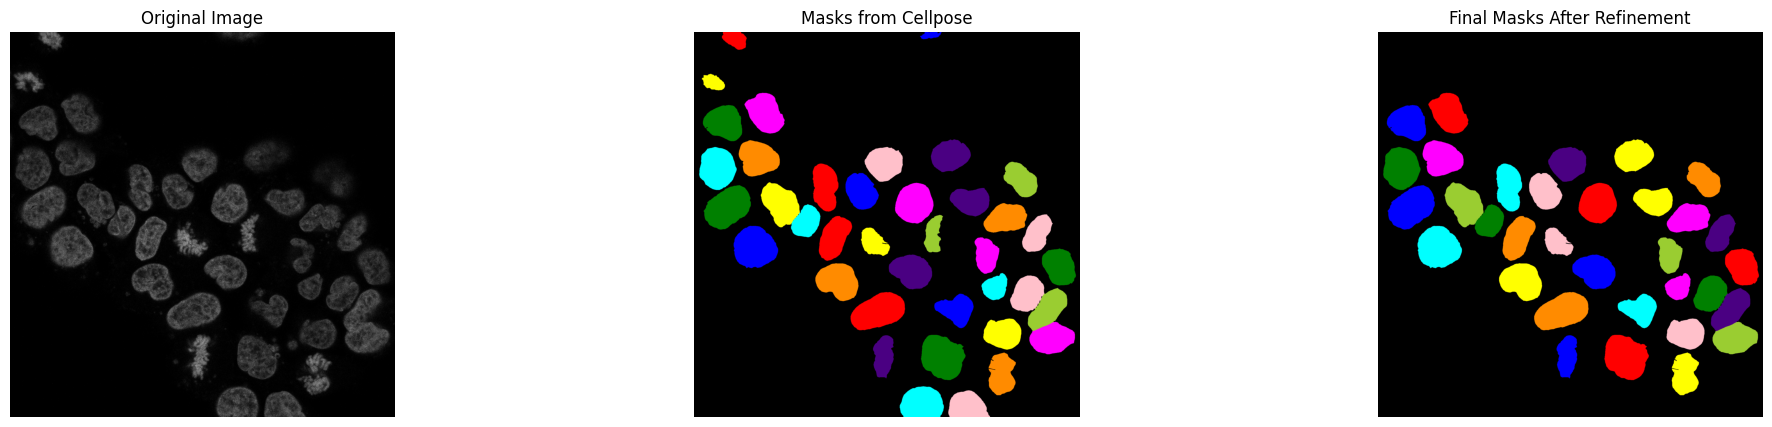

Processing image: id36_taf6lko_hoechst_kat2a_488_conv_fix_pos1-12_rep1_ignore_pos5.czi #04.tif


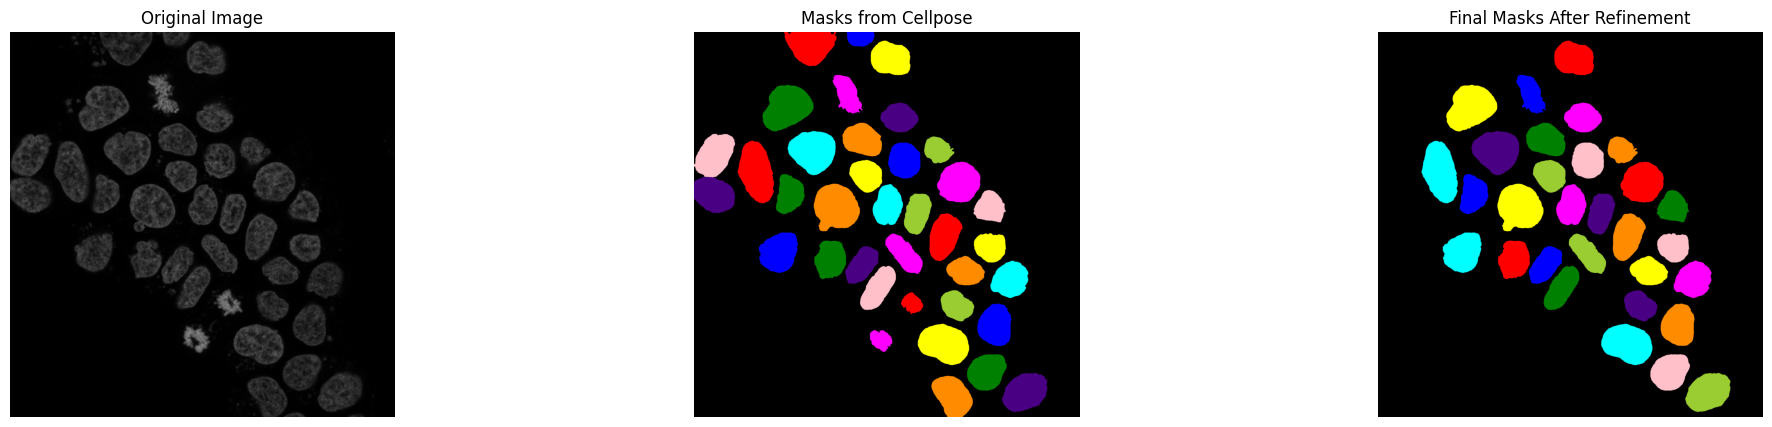

Processing image: id36_taf6lko_hoechst_kat2a_488_conv_fix_pos1-12_rep1_ignore_pos5.czi #09.tif


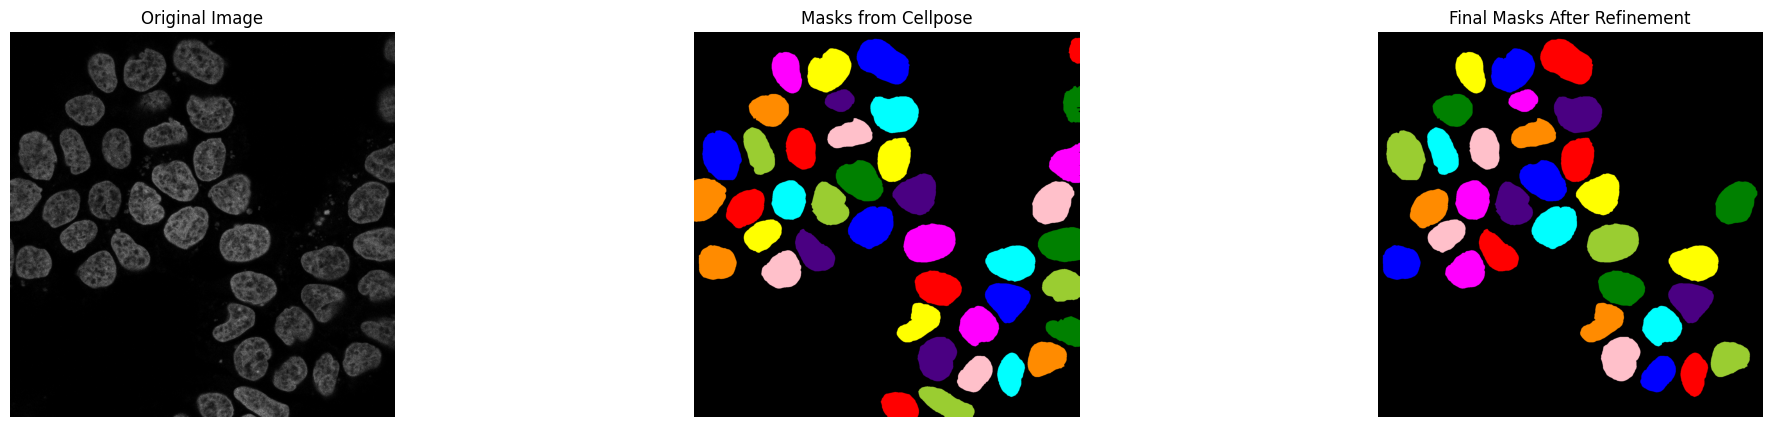

Processing image: id36_taf6lko_hoechst_kat2a_488_conv_fix_pos1-12_rep1_ignore_pos5.czi #08.tif


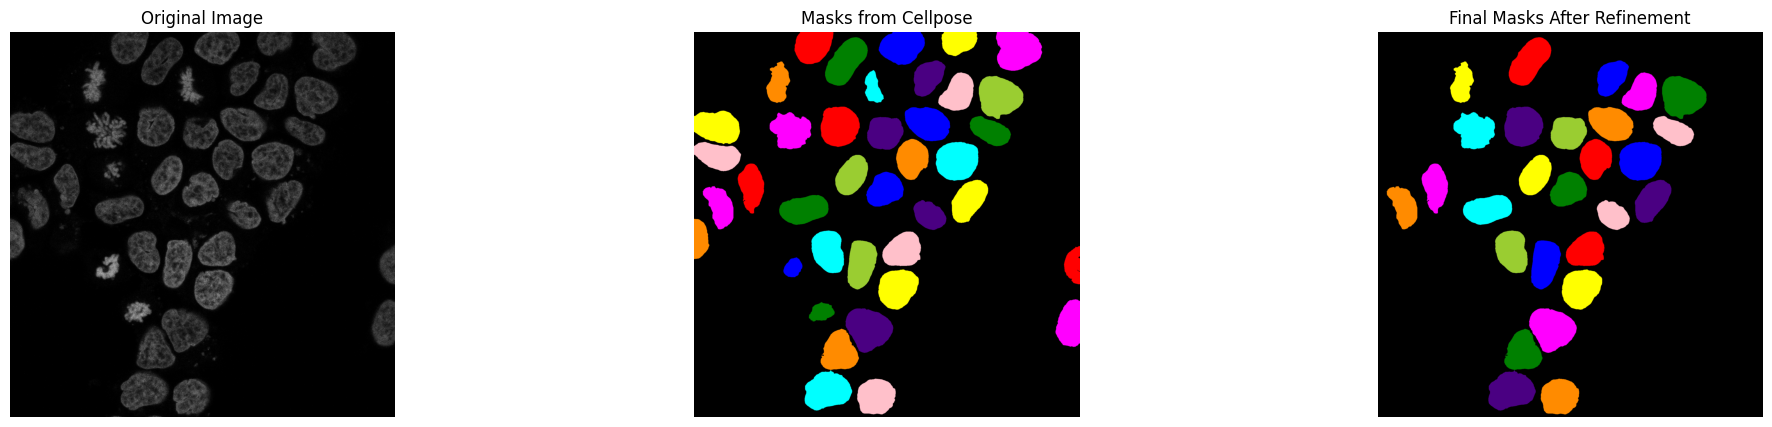

Processing image: id36_taf6lko_hoechst_kat2a_488_conv_fix_pos1-12_rep1_ignore_pos5.czi #12.tif


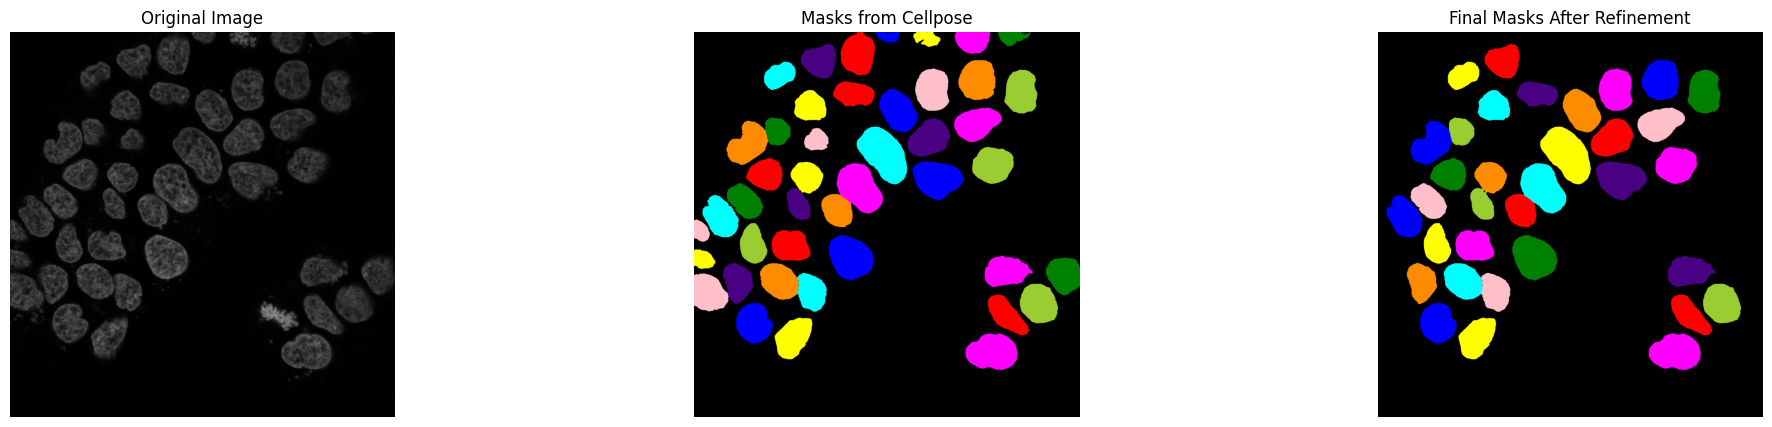

Processing image: id36_taf6lko_hoechst_kat2a_488_conv_fix_pos1-12_rep1_ignore_pos5.czi #03.tif


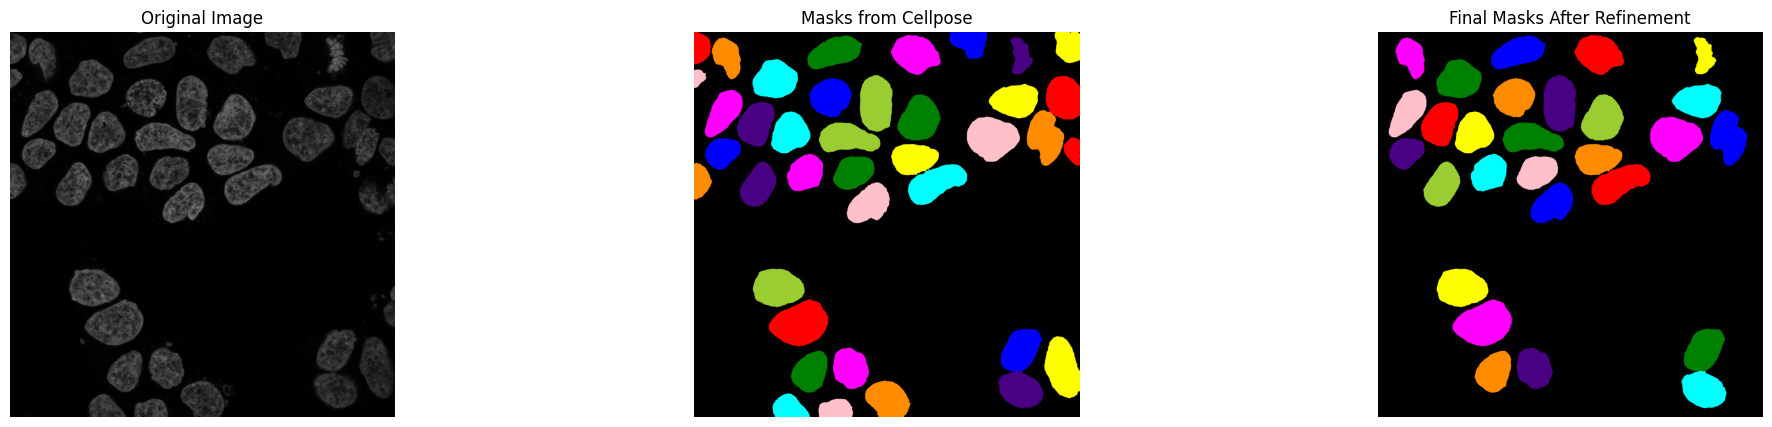

Processing image: id36_taf6lko_hoechst_kat2a_488_conv_fix_pos1-12_rep1_ignore_pos5.czi #11.tif


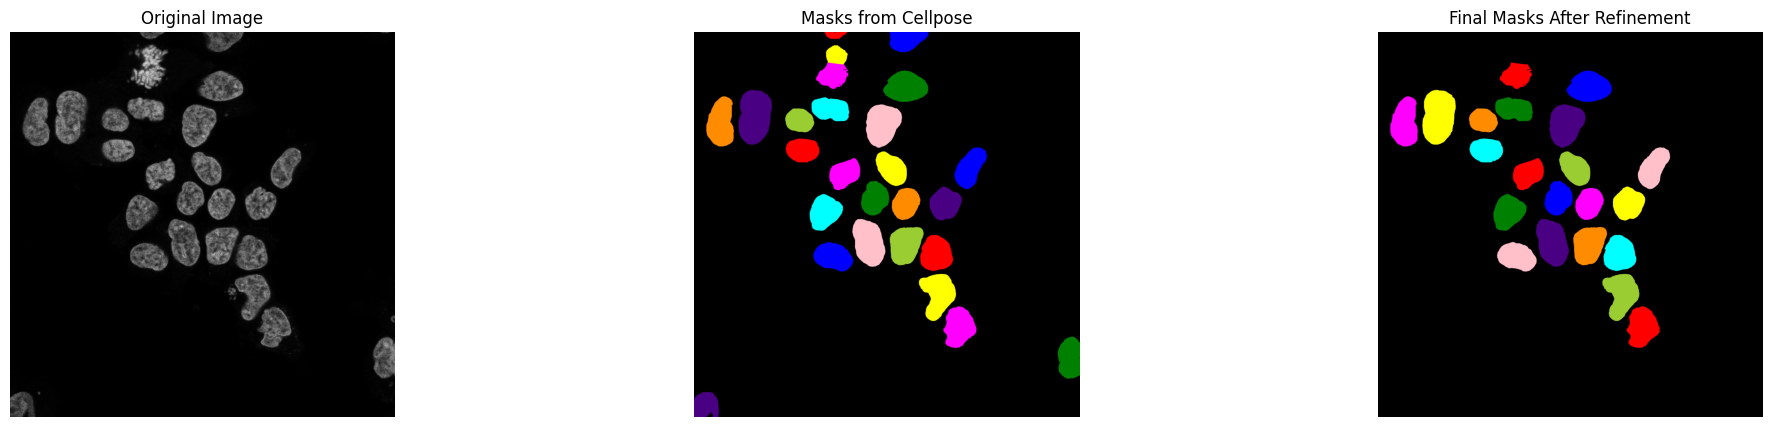

Processing image: id36_taf6lko_hoechst_kat2a_488_conv_fix_pos1-12_rep1_ignore_pos5.czi #06.tif


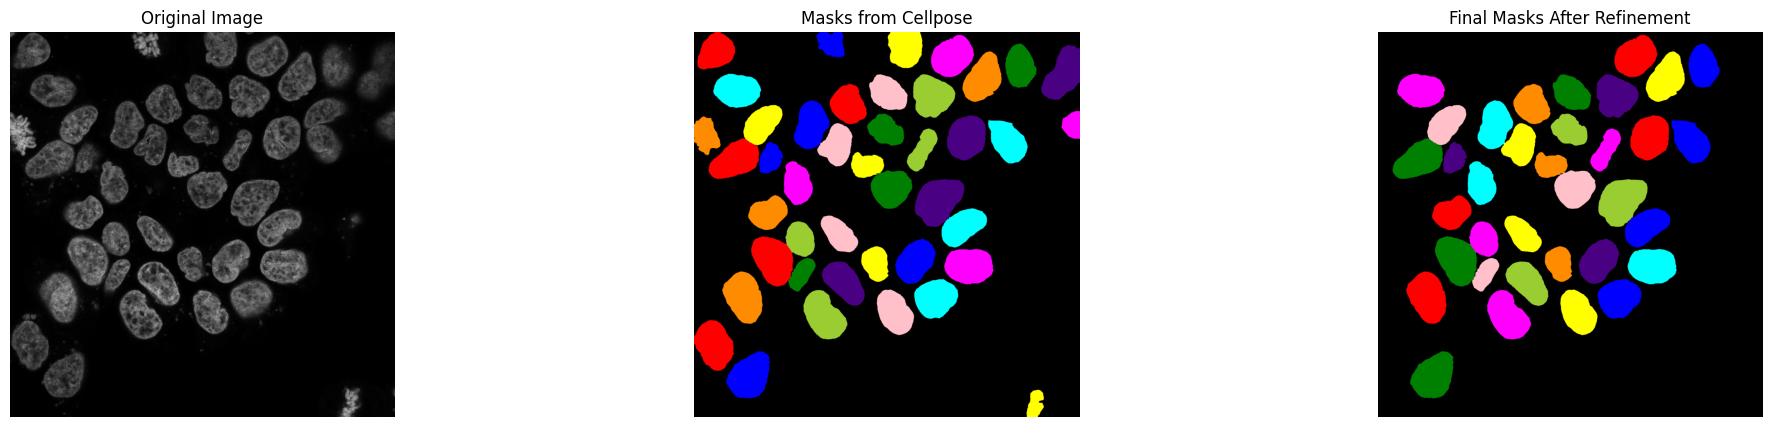

Processing image: id36_taf6lko_hoechst_kat2a_488_conv_fix_pos1-12_rep1_ignore_pos5.czi #02.tif


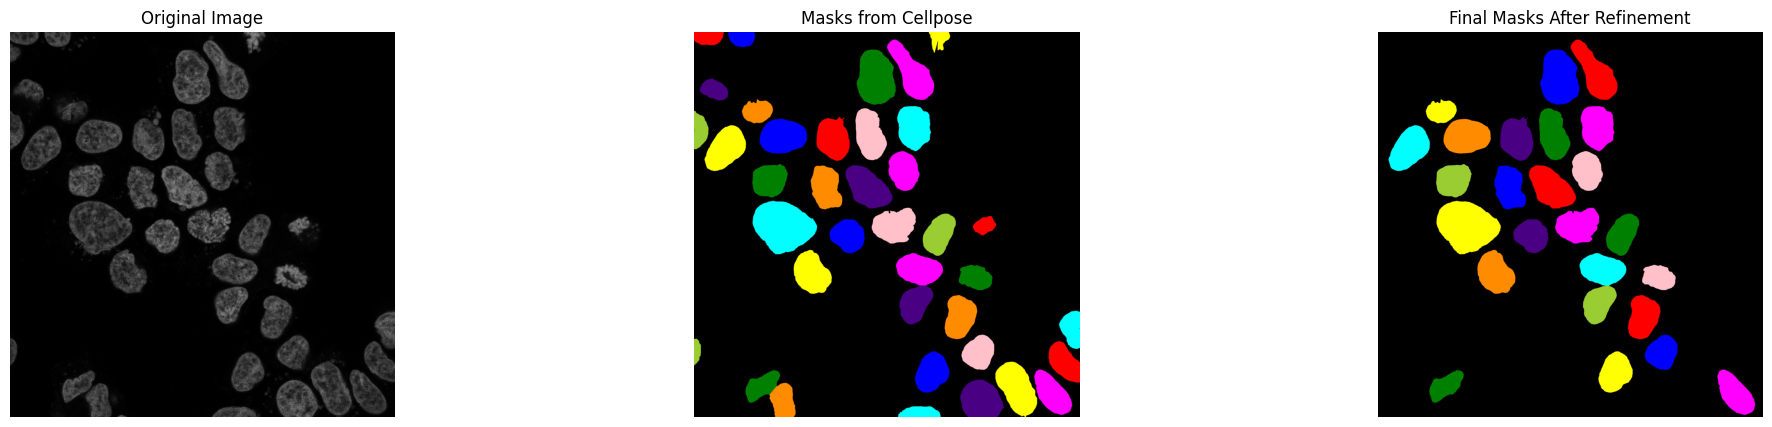

Processing image: id36_taf6lko_hoechst_kat2a_488_conv_fix_pos1-12_rep1_ignore_pos5.czi #01.tif


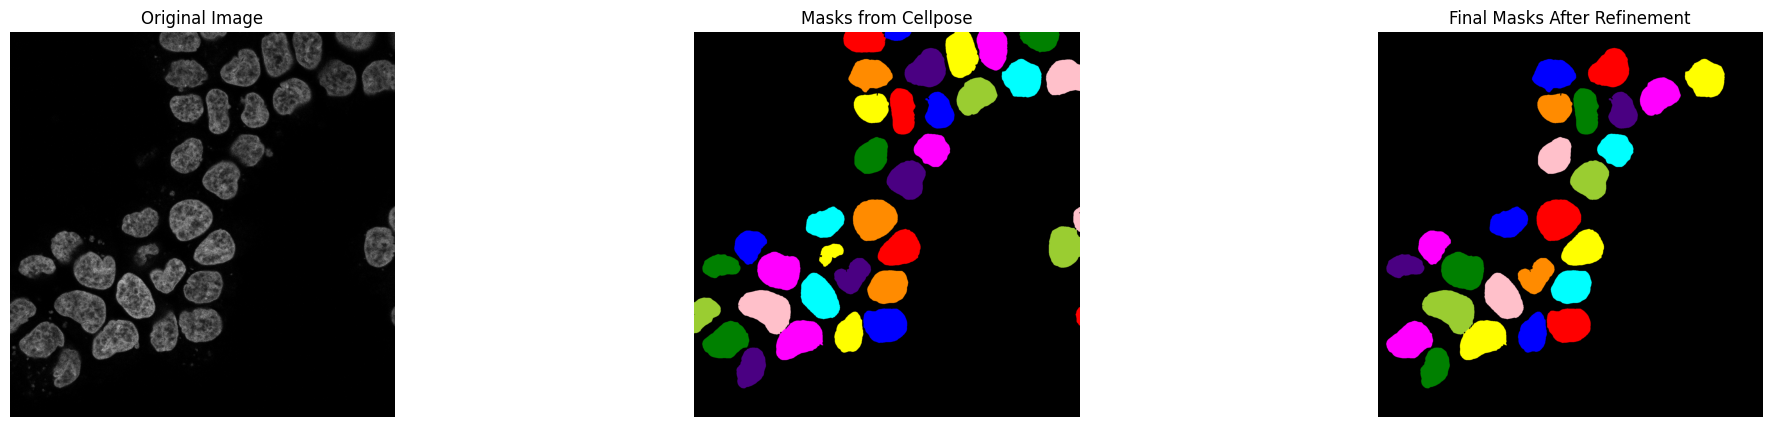

Processing image: id36_taf6lko_hoechst_kat2a_488_conv_fix_pos1-12_rep1_ignore_pos5.czi #10.tif


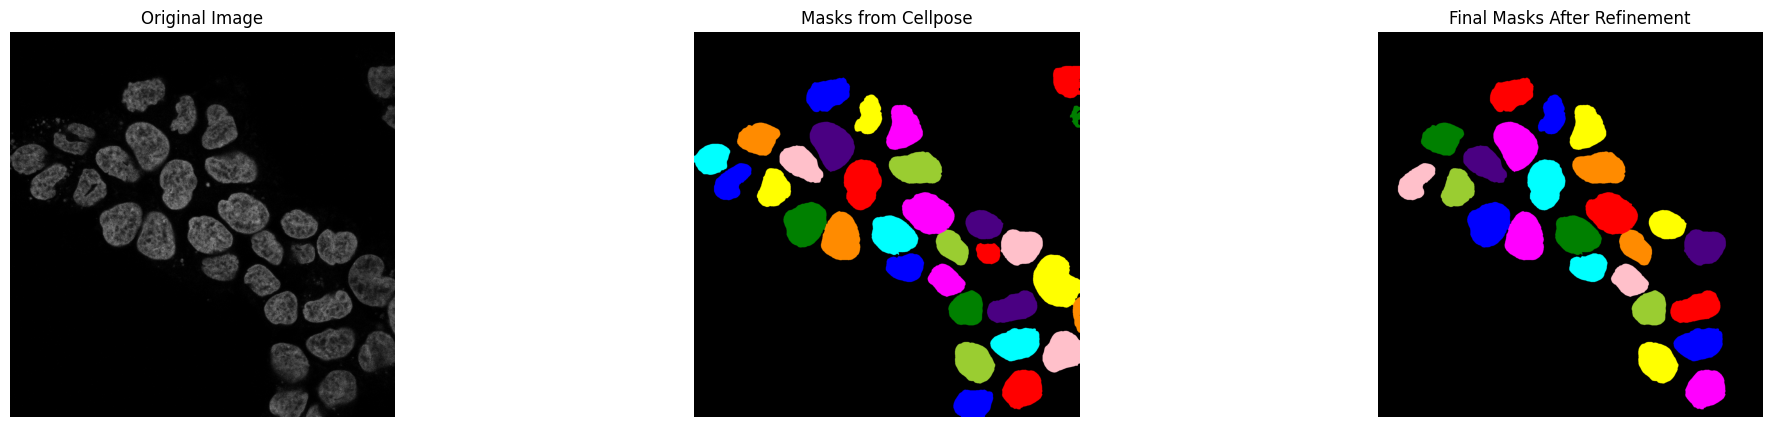

In [5]:
#call the function to threshold the cells
images_dir = "/inpath/tifs"
output_dir = "/outpath/tifs/"
threshold_field(images_dir, output_dir)